In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits

In [2]:
mnist_small = load_digits()
print("MNIST dataset loaded.")

# Each image is a 8x8 image
print("Shape of MNIST", mnist_small["data"].shape)

MNIST dataset loaded.
Shape of MNIST (1797, 64)


Target: 1


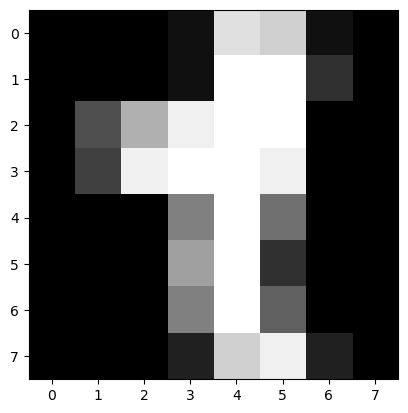

In [3]:
index = 80

digit = mnist_small["data"][index].reshape(8, 8)
plt.imshow(digit, cmap = "gray");

print("Target:", mnist_small["target"][index])

# Feature Engineering 

## [ Train-test split ]

In [4]:
def train_test_split(X, y, test_size=0.20):
    length = len(X)
    assert length == len(y), "Lengths do not match"

    # Training index
    train_split_idx = int(length * (1 - test_size))

    # Indices for test and validation
    slide = int(length * (test_size / 2))
    val_split_idx = train_split_idx + slide
    test_split_idx = val_split_idx + slide

    train_X, train_y = X[:train_split_idx], y[:train_split_idx]
    val_X, val_y = X[train_split_idx:val_split_idx], y[train_split_idx:val_split_idx]
    test_X, test_y = X[val_split_idx:test_split_idx], y[val_split_idx:test_split_idx]

    return (train_X, train_y), (val_X, val_y), (test_X, test_y)

In [5]:
X = mnist_small["data"]
y = mnist_small["target"]

In [6]:
# training dataset will be used for computing distances
# valiation dataset for hyperparameter tuning : For finding the right K
# test dataset: Unseen data -> model evaluation
train_dataset, val_dataset, test_dataset = train_test_split(X, y)

X_train, y_train = train_dataset
X_val, y_val = val_dataset
X_test, y_test = test_dataset

print("Training data shapes - X_train: {}, y_train: {}".format(X_train.shape, len(y_train)))
print("Validation data shapes - X_val: {}, y_val: {}".format(X_val.shape, len(y_val)))
print("Testing data shapes - X_test: {}, y_test: {}".format(X_test.shape, len(y_test)))

Training data shapes - X_train: (1437, 64), y_train: 1437
Validation data shapes - X_val: (179, 64), y_val: 179
Testing data shapes - X_test: (179, 64), y_test: 179


## [ Standard scaler ]

All the features should be in same scale, so scaling is necessary! We do not want any feature to dominate over the other one.

In [7]:
class StandardScaler:
    def __init__(self, mean = None, standard_dev = None, eps = 0.00001):
        self.mean = mean
        self.eps = eps
        self.standard_dev = standard_dev
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.standard_dev = np.std(X, axis=0) + self.eps
    
    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.standard_dev
    
    def transform(self, X):
        if self.mean is None and self.standard_dev is None:
            raise ValueError("fit method must be called before transform")
        return (X - self.mean) / self.standard_dev

In [8]:
scaler = StandardScaler()

# find the statistics using training dataset
scaler.fit(X_train)

In [9]:
# we do not want any feature to dominate over the other
X_train_scaled, X_val_scaled, X_test_scaled = map(lambda x: scaler.transform(x).tolist(),
                                                  [X_train, X_val, X_test])
y_train, y_val, y_test = map(np.ndarray.tolist, [y_train, y_val, y_test])

## Training KNN on MNIST

In [10]:
class KNeighborsClassifier:
    def __init__(self, n_neighbors=5, algorithm="brute", distance="l2"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.distance = distance
        
        # input and output variables, set to None
        # updated once the fit() method is called
        self.input_vars = None
        self.target = None

    def fit(self, X, y):
        self.input_vars = X
        self.target = y
        
        if self.algorithm == "brute":
            return 
        elif self.algorithm == "lsh":
            raise Exception("Not implemented")
                
            
    def predict_brute(self, query):
        dist_and_labels = []
        
        # Iterating through the labels and datapoints for computing distances
        for idata, itarget in zip(self.input_vars, self.target):
            dist = self.L2_distance(idata, query)
            dist_and_labels.append((itarget, dist)) 

        # sorting the distances in asceding order
        dist_and_labels = sorted(dist_and_labels, key = lambda x: x[1])            
        neighbours = list(map(lambda x: x[0], dist_and_labels[:self.n_neighbors]))

        # majority vote amongs the top-k points
        majority_class = self.majority_vote(neighbours)
        return majority_class
    
    
    def predict(self, X):
        if self.algorithm == "brute":
            return [self.predict_brute(q) for q in X]
    
    
    def L2_distance(self, a, b):
        assert len(a) == len(b)
        return (sum((ia - ib) ** 2 for ia, ib in zip(a, b))) ** 0.5


    def l1_distance(self, a, b):
        assert len(a) == len(b)
        return sum(abs(ia - ib) for ia, ib in zip(a, b))

    
    def majority_vote(self, neighbours):
        # Boyer moore's algorithms to find the majority
        # element. O(n) time and O(1) space
        potential = neighbours[0]
        count = 1
        
        for neigh in neighbours[1:]:
            if neigh == potential:
                count += 1
            else:
                count -= 1
                if count == 0:
                    potential = neigh
                    count = 1
        return potential
    
    def compute_accuracy(self, y_pred, y_target):
        match = 0
        for iyp, iyt in zip(y_pred, y_target):
            if iyp == iyt:
                match += 1
        return round(match / len(y_pred), 2)

In [11]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, 
        y_train)

In [12]:
X_val_prediction = knn.predict(X_val_scaled)

In [13]:
acc = knn.compute_accuracy(X_val_prediction, y_val)
print("Accuracy:", acc)

Accuracy: 0.93


## Hyperparameter tuning [K]

In [14]:
k_values = list(range(1, 50, 2))
print(k_values)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]


In [ ]:
train_accs = []
val_accs = []

for k in k_values:
    # KNeighborsClassifier with the current k
    knn = KNeighborsClassifier(n_neighbors=k, algorithm="brute", distance="l2")

    # Training
    knn.fit(X_train_scaled, y_train)

    # Prediction with current K
    y_pred_train = knn.predict(X_train_scaled)
    y_pred_val = knn.predict(X_val_scaled)

    # Computing accuracy on training and validation datasets
    train_acc = knn.compute_accuracy(y_pred_train, y_train)
    val_acc = knn.compute_accuracy(y_pred_val, y_val)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

In [ ]:
plt.plot(k_values, train_accs, label='Train Accuracy')
plt.plot(k_values, val_accs, label='Validation Accuracy')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()